<a href="https://colab.research.google.com/github/AdamClarkStandke/GenerativeDeepLearning/blob/main/DreamBoothTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DreamBooth

This notebook will implement the tutorial [DreamBooth](https://keras.io/examples/generative/dreambooth/) which is a fine-tuning technique to teach new visual concepts to text-conditioned Diffusion models. This approach is very similar to other fine-tuning methods such as [textual inversion](https://keras.io/examples/generative/fine_tune_via_textual_inversion/).


In [1]:
!pip install --upgrade keras
!pip install --upgrade keras-cv

In [2]:
import math
import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from imutils import paths
from tensorflow import keras
from tqdm import tqdm
import numpy as np
import hashlib
import keras_cv
import PIL
import os
from keras import backend as K

Found 28 files.
Found 200 files.


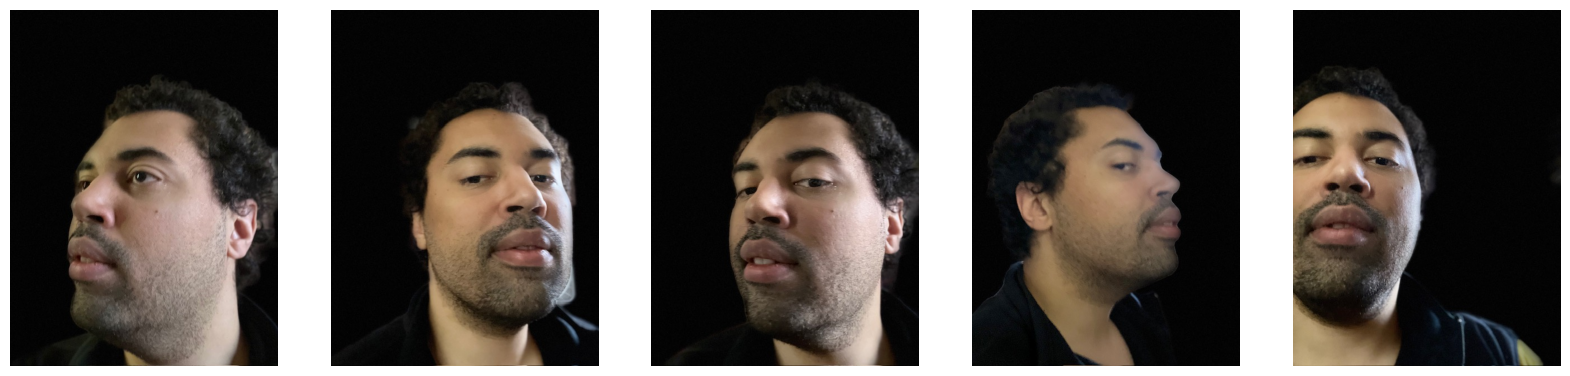

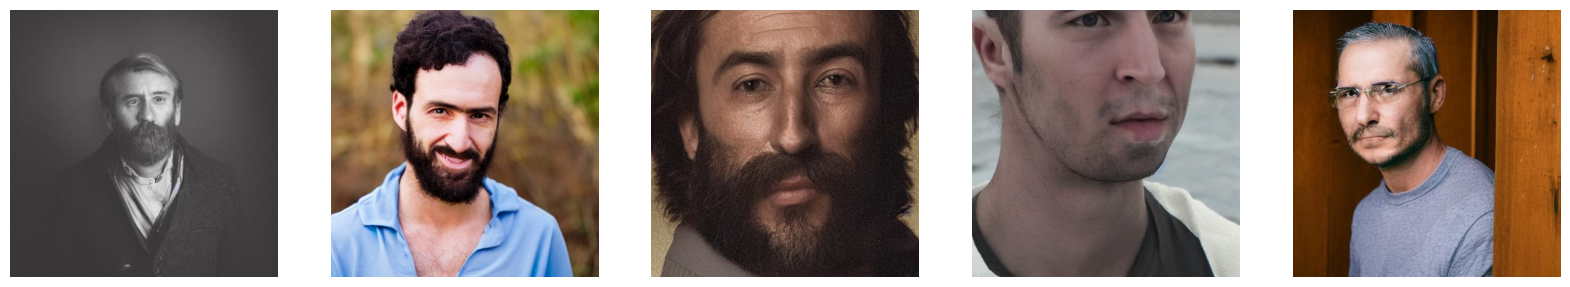

In [33]:

instance_images_root = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/faceDream/',
    labels=None
)
class_images_root  = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/class-images/',
    labels=None
)

def load_images(image_paths):
    images = [np.array(keras.utils.load_img(path)) for path in image_paths]
    return images

def plot_images(images, title=None):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        if title is not None:
            plt.title(title)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(load_images(instance_images_root.file_paths[:5]))


plot_images(load_images(class_images_root.file_paths[:5]))


new_instance_image_paths = []
for index in range(len(class_images_root.file_paths)):
    instance_image = instance_images_root.file_paths[index % len(instance_images_root.file_paths)]
    new_instance_image_paths.append(instance_image)

len(new_instance_image_paths)

unique_id = "sks"
class_label = "man"

instance_prompt = f"a photo of {unique_id} {class_label}"
instance_prompts = [instance_prompt] * len(new_instance_image_paths)

class_prompt = f"a photo of {class_label}"
class_prompts = [class_prompt] * len(class_images_root.file_paths)

import itertools

padding_token = 49407
max_prompt_length = 77

# Load the tokenizer.
tokenizer = keras_cv.models.stable_diffusion.SimpleTokenizer()

# Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [padding_token] * (max_prompt_length - len(tokens))
    return np.array(tokens)


# Collate the tokenized captions into an array.
tokenized_texts = np.empty(
    (len(instance_prompts) + len(class_prompts), max_prompt_length)
)

for i, caption in enumerate(itertools.chain(instance_prompts, class_prompts)):
    tokenized_texts[i] = process_text(caption)




resolution = 512
auto = tf.data.AUTOTUNE

augmenter = keras.Sequential(
    layers=[
        keras.layers.CenterCrop(resolution, resolution),
        keras_cv.layers.RandomFlip(),
        keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)


def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (resolution, resolution))
    return image, tokenized_text


def apply_augmentation(image_batch, embedded_tokens):
    return augmenter(image_batch), embedded_tokens


def prepare_dict(instance_only=True):
    def fn(image_batch, embedded_tokens):
        if instance_only:
            batch_dict = {
                "instance_images": image_batch,
                "instance_embedded_texts": embedded_tokens,
            }
            return batch_dict
        else:
            batch_dict = {
                "class_images": image_batch,
                "class_embedded_texts": embedded_tokens,
            }
            return batch_dict

    return fn


def assemble_dataset(image_paths, embedded_texts, instance_only=True, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, embedded_texts))
    dataset = dataset.map(process_image, num_parallel_calls=auto)
    dataset = dataset.shuffle(5, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=auto)

    prepare_dict_fn = prepare_dict(instance_only=instance_only)
    dataset = dataset.map(prepare_dict_fn, num_parallel_calls=auto)
    return dataset


instance_dataset = assemble_dataset(
    new_instance_image_paths,
    tokenized_texts[: len(new_instance_image_paths)],
)
class_dataset = assemble_dataset(
    class_images_root.file_paths,
    tokenized_texts[len(new_instance_image_paths) :],
    instance_only=False,
)
train_dataset = tf.data.Dataset.zip((instance_dataset, class_dataset))

In [34]:
train_dataset.save('/content/drive/MyDrive/DreamData')

In [3]:
train_dataset = tf.data.Dataset.load('/content/drive/MyDrive/DreamData')

In [4]:
sample_batch = next(iter(train_dataset))
print(sample_batch[0].keys(), sample_batch[1].keys())

for k in sample_batch[0]:
    print(k, sample_batch[0][k].shape)

for k in sample_batch[1]:
    print(k, sample_batch[1][k].shape)

dict_keys(['instance_embedded_texts', 'instance_images']) dict_keys(['class_embedded_texts', 'class_images'])
instance_embedded_texts (1, 77)
instance_images (1, 512, 512, 3)
class_embedded_texts (1, 77)
class_images (1, 512, 512, 3)


In [5]:
import tensorflow.experimental.numpy as tnp
from keras_cv.models.stable_diffusion import TextEncoder
from keras_cv.models.stable_diffusion import DiffusionModel
from keras_cv.models.stable_diffusion import ImageEncoder
from keras_cv.models.stable_diffusion import NoiseScheduler
from tensorflow.keras import mixed_precision
import math
PADDING_TOKEN = 49407
MAX_PROMPT_LENGTH = 77


class DreamBoothTrainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        train_text_encoder,
        use_mixed_precision=False,
        prior_loss_weight=1.0,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.diffusion_model.trainable = True

        self.vae = vae
        self.vae.trainable = False

        self.noise_scheduler = noise_scheduler

        self.train_text_encoder = train_text_encoder
        if self.train_text_encoder:
            self.text_encoder = TextEncoder(MAX_PROMPT_LENGTH)
            self.text_encoder.trainable = True
            self.pos_ids = tf.convert_to_tensor(
                [list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32
            )

        self.prior_loss_weight = prior_loss_weight
        self.max_grad_norm = max_grad_norm
        self.use_mixed_precision = use_mixed_precision
        self.mse = tf.keras.losses.MeanSquaredError()

    def train_step(self, inputs):
        instance_batch = inputs[0]
        class_batch = inputs[1]

        instance_images = instance_batch["instance_images"]
        instance_texts = instance_batch['instance_embedded_texts']
        class_images = class_batch["class_images"]
        class_texts = class_batch['class_embedded_texts']

        images = tf.concat([instance_images, class_images], 0)
        texts = tf.concat(
            [instance_texts, class_texts], 0
        )  # `texts` can either be caption tokens or embedded caption tokens.
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # If the `text_encoder` is being fine-tuned.
            if self.train_text_encoder:
                texts = self.text_encoder([texts, self.pos_ids], training=True)

            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, texts], training=True
            )
            loss = self.compute_loss(target, model_pred)
            # if self.use_mixed_precision:
            #     loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        if self.train_text_encoder:
            trainable_vars = (
                self.text_encoder.trainable_variables
                + self.diffusion_model.trainable_variables
            )
        else:
            trainable_vars = self.diffusion_model.trainable_variables

        gradients = tape.gradient(loss, trainable_vars)
        # if self.use_mixed_precision:
        #     gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(-log_max_preiod * tf.range(0, half, dtype=tf.float32) / half)
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def compute_loss(self, target, model_pred):
        # Chunk the noise and model_pred into two parts and compute the loss on each part separately.
        model_pred, model_pred_prior = tf.split(model_pred, num_or_size_splits=2, axis=0)
        target, target_prior = tf.split(target, num_or_size_splits=2, axis=0)

        # Compute instance loss.
        loss = self.mse(target, model_pred)

        # Compute prior loss.
        prior_loss = self.mse(target_prior, model_pred_prior)

        # Add the prior loss to the instance loss.
        loss = loss + self.prior_loss_weight * prior_loss
        return loss

    def save_weights(
        self, ckpt_path_prefix, overwrite=True, save_format=None, options=None
    ):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` and optionally the `text_encoder`.
        diffusion_model_path = ckpt_path_prefix + "-unet.h5"
        self.diffusion_model.save_weights(
            filepath=diffusion_model_path,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )
        self.diffusion_model_path = diffusion_model_path
        if self.train_text_encoder:
            text_encoder_model_path = ckpt_path_prefix + "-text_encoder.h5"
            self.text_encoder.save_weights(
                filepath=text_encoder_model_path,
                overwrite=overwrite,
                save_format=save_format,
                options=options,
            )
            self.text_encoder_model_path = text_encoder_model_path

In [6]:
def get_optimizer(
    lr=1e-6, beta_1=0.9, beta_2=0.999, weight_decay=(1e-2,), epsilon=1e-08
):
    """Instantiates the AdamW optimizer."""

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=lr,
        weight_decay=weight_decay,
        beta_1=beta_1,
        beta_2=beta_2,
        epsilon=epsilon,
    )

    return optimizer


def prepare_trainer(
    img_resolution, train_text_encoder, use_mp, **kwargs
):
    """Instantiates and compiles `DreamBoothTrainer` for training."""
    image_encoder = ImageEncoder(img_resolution)

    dreambooth_trainer = DreamBoothTrainer(
        diffusion_model=DiffusionModel(
            img_resolution, img_resolution, MAX_PROMPT_LENGTH
        ),
        # Remove the top layer from the encoder, which cuts off
        # the variance and only returns the mean.
        vae=tf.keras.Model(
            image_encoder.inputs,
            image_encoder.layers[-2].output,
        ),
        noise_scheduler=NoiseScheduler(),
        train_text_encoder=train_text_encoder,
        use_mixed_precision=use_mp,
        **kwargs,
    )

    optimizer = get_optimizer()
    dreambooth_trainer.compile(optimizer=optimizer, loss='mse')
    print("DreamBooth trainer initialized and compiled.")
    return dreambooth_trainer




policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)
ckpt_path = '.weights.h5'
dreambooth_trainer = prepare_trainer(512, True, True)
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    monitor="loss",
    mode="min",
)
num_update_steps_per_epoch = train_dataset.cardinality()
epochs = math.ceil(1200 / num_update_steps_per_epoch)
print(f"Training for {epochs} epochs.")

dreambooth_trainer.fit(train_dataset, epochs=epochs, callbacks=[ckpt_callback])

DreamBooth trainer initialized and compiled.
Training for 6 epochs.
Epoch 1/6


Instructions for updating:
Use fn_output_signature instead


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-6-015e191cba9c>", line 61, in <cell line: 61>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 323, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

Out of memory while trying to allocate 6876899952 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   11.11GiB
              constant allocation:    12.2KiB
        maybe_live_out allocation:   10.98GiB
     preallocated temp allocation:    6.40GiB
  preallocated temp fragmentation:   27.96MiB (0.43%)
                 total allocation:   17.52GiB
Peak buffers:
	Buffer 1:
		Size: 512.00MiB
		Operator: op_type="Mul" op_name="gradient_tape/diffusion_model_1/spatial_transformer_15_1/basic_transformer_block_15_1/cross_attention_30_1/mul/Mul" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.6307"
		XLA Label: fusion
		Shape: f16[2,8,4096,4096]
		==========================

	Buffer 2:
		Size: 512.00MiB
		Operator: op_type="Softmax" op_name="diffusion_model_1/spatial_transformer_15_1/basic_transformer_block_15_1/cross_attention_30_1/Softmax" deduplicated_name="fusion.8232"
		XLA Label: fusion
		Shape: f16[2,8,4096,4096]
		==========================

	Buffer 3:
		Size: 512.00MiB
		Operator: op_type="Softmax" op_name="diffusion_model_1/spatial_transformer_14_1/basic_transformer_block_14_1/cross_attention_28_1/Softmax" deduplicated_name="fusion.8232"
		XLA Label: fusion
		Shape: f16[2,8,4096,4096]
		==========================

	Buffer 4:
		Size: 512.00MiB
		Operator: op_type="Softmax" op_name="diffusion_model_1/spatial_transformer_13_1/basic_transformer_block_13_1/cross_attention_26_1/Softmax" deduplicated_name="fusion.8232"
		XLA Label: fusion
		Shape: f16[2,8,4096,4096]
		==========================

	Buffer 5:
		Size: 512.00MiB
		Operator: op_type="Softmax" op_name="diffusion_model_1/spatial_transformer_1_2/basic_transformer_block_1_1/cross_attention_2_1/Softmax" deduplicated_name="fusion.8232"
		XLA Label: fusion
		Shape: f16[2,8,4096,4096]
		==========================

	Buffer 6:
		Size: 512.00MiB
		Operator: op_type="Softmax" op_name="diffusion_model_1/spatial_transformer_1/basic_transformer_block_1/cross_attention_1/Softmax" deduplicated_name="fusion.8232"
		XLA Label: fusion
		Shape: f16[2,8,4096,4096]
		==========================

	Buffer 7:
		Size: 144.75MiB
		Operator: op_type="AssignSubVariableOp" op_name="cond/adamw/AssignSubVariableOp_882" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: fusion
		Shape: f32[49408,768]
		==========================

	Buffer 8:
		Size: 144.75MiB
		Operator: op_type="AssignSubVariableOp" op_name="cond/adamw/AssignSubVariableOp_882" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: fusion
		Shape: f32[49408,768]
		==========================

	Buffer 9:
		Size: 144.75MiB
		Operator: op_type="AssignSubVariableOp" op_name="cond/adamw/AssignSubVariableOp_882" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: fusion
		Shape: f32[49408,768]
		==========================

	Buffer 10:
		Size: 112.50MiB
		Operator: op_type="AssignSubVariableOp" op_name="cond/adamw/AssignSubVariableOp_1416" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.1405"
		XLA Label: fusion
		Shape: f32[3,3,2560,1280]
		==========================

	Buffer 11:
		Size: 112.50MiB
		Operator: op_type="AssignSubVariableOp" op_name="cond/adamw/AssignSubVariableOp_1402" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.1405"
		XLA Label: fusion
		Shape: f32[3,3,2560,1280]
		==========================

	Buffer 12:
		Size: 112.50MiB
		Operator: op_type="AssignSubVariableOp" op_name="cond/adamw/AssignSubVariableOp_1402" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.1405"
		XLA Label: fusion
		Shape: f32[3,3,2560,1280]
		==========================

	Buffer 13:
		Size: 112.50MiB
		Operator: op_type="AssignSubVariableOp" op_name="cond/adamw/AssignSubVariableOp_1390" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.1405"
		XLA Label: fusion
		Shape: f32[3,3,2560,1280]
		==========================

	Buffer 14:
		Size: 112.50MiB
		Operator: op_type="AssignSubVariableOp" op_name="cond/adamw/AssignSubVariableOp_1390" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.1405"
		XLA Label: fusion
		Shape: f32[3,3,2560,1280]
		==========================

	Buffer 15:
		Size: 112.50MiB
		Operator: op_type="AssignSubVariableOp" op_name="cond/adamw/AssignSubVariableOp_1378" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: fusion
		Shape: f32[3,3,2560,1280]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_313063]